<a href="https://colab.research.google.com/github/duridudu/musinsa_closet/blob/main/MLCR_Fashion_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PERSONALIZED FASHION RECOMMENDATION SYSTEM

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd '/content/drive/MyDrive/Colab Notebooks/추천 시스템'

/content/drive/MyDrive/Colab Notebooks/추천 시스템


## MACHINE LEARNING CLUSTERING AND RETRIEVAL

Importing Libraries

In [3]:
# for loading/processing the images  
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle

In [4]:
path = "/content/drive/MyDrive/Colab Notebooks/추천 시스템/여성걸리시_images"
# change the working directory to the path where the images are located
os.chdir(path)

# this list holds all the image filename
fashion = []

# creates a ScandirIterator aliased as files
with os.scandir(path) as files:
  # loops through each file in the directory
    for file in files:
        fashion.append(file.name)

In [5]:
print(fashion[:10])

['867.jpg', '868.jpg', '870.jpg', '871.jpg', '869.jpg', '865.jpg', '872.jpg', '875.jpg', '876.jpg', '873.jpg']


### IMAGE RESHAPING AND VECTORIZATION

In [6]:
# load the image as a 224x224 array
img = load_img(fashion[0], target_size=(224,224))
# convert from 'PIL.Image.Image' to numpy array
img = np.array(img)

print(img.shape)
(224, 224, 3)

(224, 224, 3)


(224, 224, 3)

In [7]:
reshaped_img = img.reshape(1,224,224,3)
print(reshaped_img.shape)
(1, 224, 224, 3)

(1, 224, 224, 3)


(1, 224, 224, 3)

In [8]:
x = preprocess_input(reshaped_img)

In [9]:
# load model
model = VGG16()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

553476096/553467096 [==============================] - 3s 0us/step


In [10]:
# load the model first and pass as an argument
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [11]:
data = {}
p = r"/content/drive/MyDrive/Colab Notebooks/추천 시스템/여성걸리시_images"

# loop through each image in the dataset
for clothes in fashion:
    # try to extract the features and update the dictionary
    try:
        feat = eatuextract_fres(clothes,model)
        data[clothes] = feat
    except FileNotFoundError:
        print('File not found!!', clothes)
        continue    
    # If any other error occurs, print the file name
    except Exception:
        print('Another Error!!', clothes)
        continue

In [12]:

# get a list of the filenames
filenames = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))
feat.shape
(210, 1, 4096)

# reshape so that there are 210 samples of 4096 vectors
feat = feat.reshape(-1,4096)
feat.shape
(210, 4096)

# get the unique labels (from the flower_labels.csv)
#df = pd.read_csv("E:\MLCR\Dataset")
#label = df['label'].tolist()
#unique_labels = list(set(label))

(210, 4096)

PCA - PRINCIPLE COMPONENT ANALYSIS

In [13]:
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

In [14]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=5756, 
                  n_features=2, 
                  centers=20, 
                  cluster_std=0.5, 
                  shuffle=True, 
                  random_state=0)

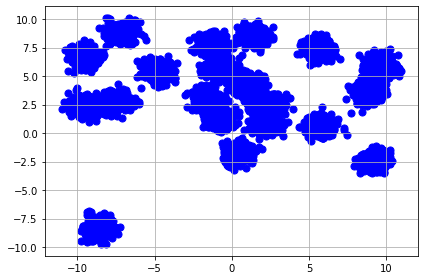

In [15]:
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c='blue', marker='o', s=50)
plt.grid()
plt.tight_layout()
plt.show()

## K MEANS CLUSTERING

In [17]:
kmeans = KMeans(n_clusters=20, random_state=22)
kmeans.fit(x)

KMeans(n_clusters=20, random_state=22)

In [18]:
kmeans.labels_

array([15,  1, 17, ..., 18, 15, 18], dtype=int32)

In [19]:
y_km = kmeans.fit_predict(X)

ELBOW METHOD

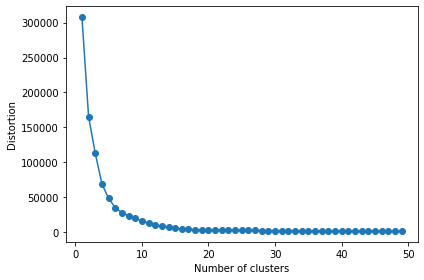

In [20]:
distortions = []
for i in range(1, 50):
    km = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                random_state=0)
    km.fit(X)
    distortions.append(km.inertia_)
plt.plot(range(1, 50), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
plt.show()

SILHOUETTE METHOD

In [21]:
from matplotlib import cm
from sklearn.metrics import silhouette_samples

km = KMeans(n_clusters=7, 
            init='k-means++', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(x)

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(i / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.tight_layout()
plt.show()

ValueError: ignored

In [22]:
from matplotlib import cm
from sklearn.metrics import silhouette_samples

km = KMeans(n_clusters=11, 
            init='k-means++', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(x)

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(i / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.tight_layout()
plt.show()

ValueError: ignored

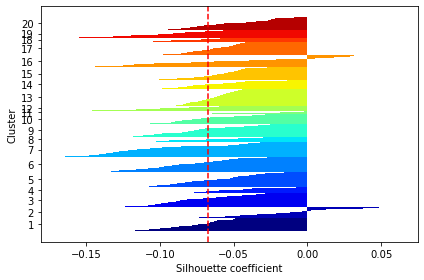

In [ ]:
from matplotlib import cm
from sklearn.metrics import silhouette_samples

km = KMeans(n_clusters=20, 
            init='k-means++', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(x)

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(i / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.tight_layout()
plt.show()

In [25]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [26]:
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 30:
        print(f"Clipping cluster size from {len(files)} to 30")
        files = files[:29]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

Clipping cluster size from 101 to 30


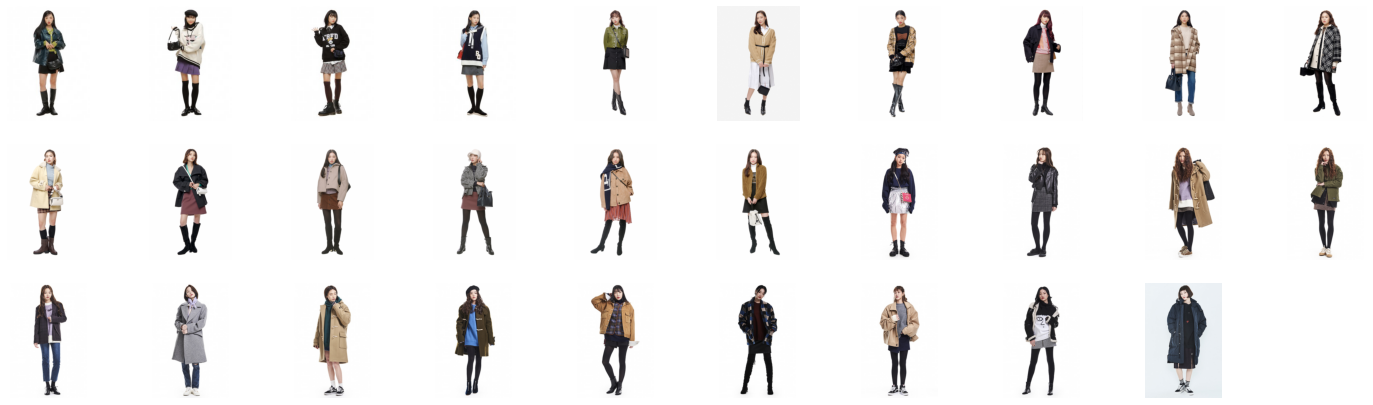

In [40]:
view_cluster(19)

## GAUSSIAN MIXTURE MODEL

In [28]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=20)
gmm.fit(x)

#predictions from gmm
labels = gmm.predict(x)


In [29]:
groups = {}
for file, cluster in zip(filenames,labels):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 30:
        print(f"Clipping cluster size from {len(files)} to 30")
        files = files[:29]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

Clipping cluster size from 88 to 30


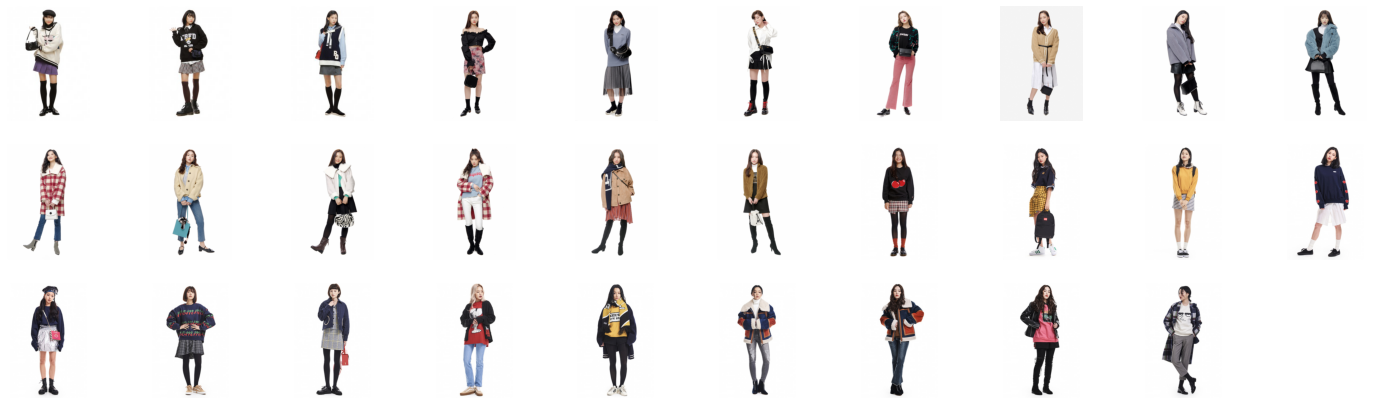

In [30]:
view_cluster(8)

## AGGLOMERATIVE CLUSTERING

In [31]:
from sklearn.cluster import AgglomerativeClustering
aggmodel = AgglomerativeClustering(n_clusters=20, affinity='euclidean')
aggmodel.fit(x)

AgglomerativeClustering(n_clusters=20)

In [32]:
groups = {}
for file, cluster in zip(filenames,aggmodel.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 30:
        print(f"Clipping cluster size from {len(files)} to 30")
        files = files[:29]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

Clipping cluster size from 61 to 30


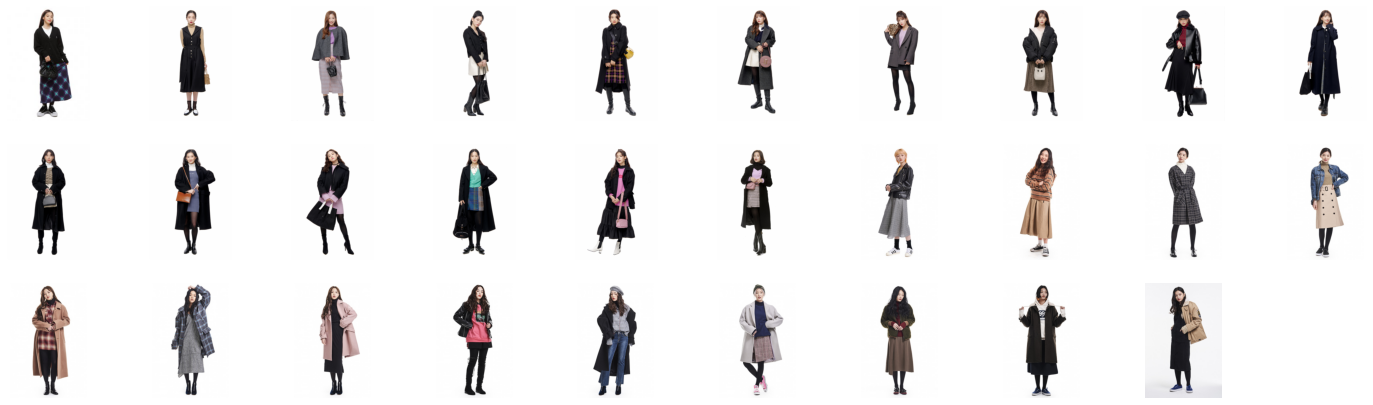

In [33]:
view_cluster(8)